In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory as trj

import h5py
import ray
# ray.init(num_cpus=1)


In [2]:
'''
TEMPERATURE PLOTS

'''

@ray.remote
def plot_year_rmse(path, year):
    
    import matplotlib
    import matplotlib.pylab as plt
    import matplotlib.pyplot as maplt
    matplotlib.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 3
    
    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    diff = True
    show_date = False
    with open(path, 'rb') as file:
        results = pickle.load(file)
    rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase = copy.deepcopy(results[0])
    for i in results[1:]:
        if not (np.shape(i[0][50000]) == 0):
            for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
                rmse_sum_shbase_sonde[k]  = rmse_sum_shbase_sonde[k] + i[0][k]
                rmse_sum_shbase_adjsonde[k] = rmse_sum_shbase_adjsonde[k] + i[1][k]
                rmse_sum_shdisp_sonde[k] = rmse_sum_shdisp_sonde[k] + i[2][k]
                rmse_sum_shdisp_adjsonde[k] = rmse_sum_shdisp_adjsonde[k] + i[3][k]
                rms_sum_shbase[k] = rms_sum_shbase[k] + i[4][k]
                rms_sum_adjsonde[k] =  rms_sum_adjsonde[k] + i[5][k]
                rms_sum_sonde[k] = rms_sum_sonde[k] + i[6][k]
                rms_sum_shdisp[k] =  rms_sum_shdisp[k] + i[7][k]
                rms_sum_dispminusbase[k] = rms_sum_dispminusbase[k] + i[8][k]

    print('done opening')
        
    limit = [1,99]
    for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_sonde[k], limit)
        rmse_sum_shbase_sonde[k]  = np.array(rmse_sum_shbase_sonde[k])
        print(len(rmse_sum_shbase_sonde[k][~numpy.isnan(rmse_sum_shbase_sonde[k])]))
        rmse_sum_shbase_sonde[k][np.logical_and(rmse_sum_shbase_sonde[k] < outlier_drop[0], rmse_sum_shbase_sonde[k] > outlier_drop[1])] = np.nan
        print(len(rmse_sum_shbase_sonde[k][~numpy.isnan(rmse_sum_shbase_sonde[k])]))
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_adjsonde[k], limit)
        rmse_sum_shbase_adjsonde[k]  = np.array(rmse_sum_shbase_adjsonde[k])
        rmse_sum_shbase_adjsonde[k][np.logical_and(rmse_sum_shbase_adjsonde[k] < outlier_drop[0], rmse_sum_shbase_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_sonde[k], limit)
        rmse_sum_shdisp_sonde[k]  = np.array(rmse_sum_shdisp_sonde[k])
        rmse_sum_shdisp_sonde[k][np.logical_and(rmse_sum_shdisp_sonde[k] < outlier_drop[0], rmse_sum_shdisp_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_adjsonde[k], limit)
        rmse_sum_shdisp_adjsonde[k]  = np.array(rmse_sum_shdisp_adjsonde[k])
        rmse_sum_shdisp_adjsonde[k][np.logical_and(rmse_sum_shdisp_adjsonde[k] < outlier_drop[0], rmse_sum_shdisp_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shbase[k], limit)
        rms_sum_shbase[k]  = np.array(rms_sum_shbase[k])
        rms_sum_shbase[k][np.logical_and(rms_sum_shbase[k] < outlier_drop[0], rms_sum_shbase[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_adjsonde[k], limit)
        rms_sum_adjsonde[k]  = np.array(rms_sum_adjsonde[k])
        rms_sum_adjsonde[k][np.logical_and(rms_sum_adjsonde[k] < outlier_drop[0], rms_sum_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_sonde[k], limit)
        rms_sum_sonde[k]  = np.array(rms_sum_sonde[k])
        rms_sum_sonde[k][np.logical_and(rms_sum_sonde[k] < outlier_drop[0], rms_sum_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shdisp[k], limit)
        rms_sum_shdisp[k]  = np.array(rms_sum_shdisp[k])
        rms_sum_shdisp[k][np.logical_and(rms_sum_shdisp[k] < outlier_drop[0], rms_sum_shdisp[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_dispminusbase[k], limit)
        rms_sum_dispminusbase[k]  = np.array(rms_sum_dispminusbase[k])
        rms_sum_dispminusbase[k][np.logical_and(rms_sum_dispminusbase[k] < outlier_drop[0], rms_sum_dispminusbase[k] > outlier_drop[1])] = np.nan
        
    print('done outlier removal')
        
    print('valid ascents: ', len(rms_sum_shdisp[50000]))
    t0 = time.time()
    rmse_shbase_sonde=[]
    rmse_shbase_adjsonde=[]
    rmse_shdisp_sonde=[]
    rmse_shdisp_adjsonde=[]

    rms_shbase=[]
    rms_adjsonde=[]
    rms_sonde=[]
    rms_shdisp=[]
    rms_dispmbase=[]

    for i in range(len(stdplevs)):
        print('calc: ', i)
        rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
        rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
        rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
        rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

        rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
        if show_date:    
            print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
        rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
        rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
        rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
        if show_date:
            print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
        rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
        if show_date:
            print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


    print('')

    fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
#     fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax1 = ax[0]
    ax2 = ax[1] 
    ax2.sharey(ax1)
    ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_shbase_sonde')
    ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_shdisp_sonde')

    ax1_4 = ax1.twiny()
    ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
    if diff:
        ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
    ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

    ax1_4.legend(loc='upper right')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('Temperature RMSE')
    ax1.legend(loc='lower right')
    ax1.grid()
    
    value_nr = []
    for i in rmse_sum_shbase_sonde:
        value_nr.append(len(rmse_sum_shbase_sonde[i][~np.isnan(rmse_sum_shbase_sonde[i])]))
#     print(value_nr)
#     print(stdplevs)
    ax2.barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax2.set_xlabel('Observations')
#     ax2.set_yticklabels([])
    ax2.tick_params(labelleft=False)
    ax2.grid()

#         maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations    ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.title(str(year)+' Temperature RMSE \n' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.tight_layout()
#     for axis in fig.gcf().axes:
#         try:
#             ax.label_outer()
#         except:
#             pass
    maplt.savefig(str(year)+'_era5_fc_outlier_cleaned_world_rmse_plot.png')
    maplt.show()
    maplt.close()
    print('RMSE calculation: ', time.time()-t0)

In [5]:
'''
HUMIDITY PLOTS

'''

# @ray.remote
def plot_year_rmse(path, year):
    
    import matplotlib
    import matplotlib.pylab as plt
    import matplotlib.pyplot as maplt
    matplotlib.rcParams.update({'font.size': 20})
    plt.rcParams['lines.linewidth'] = 3
    
    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    diff = True
    show_date = False
    with open(path, 'rb') as file:
        results = pickle.load(file)
    rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde, rms_sum_shdisp, rms_sum_dispminusbase = copy.deepcopy(results[0])
    for i in results[1:]:
        if not (np.shape(i[0][50000]) == 0):
            for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
                rmse_sum_shbase_sonde[k]  = rmse_sum_shbase_sonde[k] + i[0][k]
                rmse_sum_shbase_adjsonde[k] = rmse_sum_shbase_adjsonde[k] + i[1][k]
                rmse_sum_shdisp_sonde[k] = rmse_sum_shdisp_sonde[k] + i[2][k]
                rmse_sum_shdisp_adjsonde[k] = rmse_sum_shdisp_adjsonde[k] + i[3][k]
                rms_sum_shbase[k] = rms_sum_shbase[k] + i[4][k]
                rms_sum_adjsonde[k] =  rms_sum_adjsonde[k] + i[5][k]
                rms_sum_sonde[k] = rms_sum_sonde[k] + i[6][k]
                rms_sum_shdisp[k] =  rms_sum_shdisp[k] + i[7][k]
                rms_sum_dispminusbase[k] = rms_sum_dispminusbase[k] + i[8][k]

    print('done opening')
        
    limit = [1,99]
    for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_sonde[k], limit)
        rmse_sum_shbase_sonde[k]  = np.array(rmse_sum_shbase_sonde[k])
        print(len(rmse_sum_shbase_sonde[k][~numpy.isnan(rmse_sum_shbase_sonde[k])]))
        rmse_sum_shbase_sonde[k][np.logical_and(rmse_sum_shbase_sonde[k] < outlier_drop[0], rmse_sum_shbase_sonde[k] > outlier_drop[1])] = np.nan
        print(len(rmse_sum_shbase_sonde[k][~numpy.isnan(rmse_sum_shbase_sonde[k])]))
        
        outlier_drop = np.nanpercentile(rmse_sum_shbase_adjsonde[k], limit)
        rmse_sum_shbase_adjsonde[k]  = np.array(rmse_sum_shbase_adjsonde[k])
        rmse_sum_shbase_adjsonde[k][np.logical_and(rmse_sum_shbase_adjsonde[k] < outlier_drop[0], rmse_sum_shbase_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_sonde[k], limit)
        rmse_sum_shdisp_sonde[k]  = np.array(rmse_sum_shdisp_sonde[k])
        rmse_sum_shdisp_sonde[k][np.logical_and(rmse_sum_shdisp_sonde[k] < outlier_drop[0], rmse_sum_shdisp_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_shdisp_adjsonde[k], limit)
        rmse_sum_shdisp_adjsonde[k]  = np.array(rmse_sum_shdisp_adjsonde[k])
        rmse_sum_shdisp_adjsonde[k][np.logical_and(rmse_sum_shdisp_adjsonde[k] < outlier_drop[0], rmse_sum_shdisp_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shbase[k], limit)
        rms_sum_shbase[k]  = np.array(rms_sum_shbase[k])
        rms_sum_shbase[k][np.logical_and(rms_sum_shbase[k] < outlier_drop[0], rms_sum_shbase[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_adjsonde[k], limit)
        rms_sum_adjsonde[k]  = np.array(rms_sum_adjsonde[k])
        rms_sum_adjsonde[k][np.logical_and(rms_sum_adjsonde[k] < outlier_drop[0], rms_sum_adjsonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_sonde[k], limit)
        rms_sum_sonde[k]  = np.array(rms_sum_sonde[k])
        rms_sum_sonde[k][np.logical_and(rms_sum_sonde[k] < outlier_drop[0], rms_sum_sonde[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_shdisp[k], limit)
        rms_sum_shdisp[k]  = np.array(rms_sum_shdisp[k])
        rms_sum_shdisp[k][np.logical_and(rms_sum_shdisp[k] < outlier_drop[0], rms_sum_shdisp[k] > outlier_drop[1])] = np.nan
        
        outlier_drop = np.nanpercentile(rms_sum_dispminusbase[k], limit)
        rms_sum_dispminusbase[k]  = np.array(rms_sum_dispminusbase[k])
        rms_sum_dispminusbase[k][np.logical_and(rms_sum_dispminusbase[k] < outlier_drop[0], rms_sum_dispminusbase[k] > outlier_drop[1])] = np.nan
        
    print('done outlier removal')
        
    print('valid ascents: ', len(rms_sum_shdisp[50000]))
    t0 = time.time()
    rmse_shbase_sonde=[]
    rmse_shbase_adjsonde=[]
    rmse_shdisp_sonde=[]
    rmse_shdisp_adjsonde=[]

    rms_shbase=[]
    rms_adjsonde=[]
    rms_sonde=[]
    rms_shdisp=[]
    rms_dispmbase=[]

    for i in range(len(stdplevs)):
        print('calc: ', i)
        rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
        rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
        rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
        rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

        rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
        if show_date:    
            print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
        rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
        rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
        if show_date:    
            print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
        rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
        if show_date:
            print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
        rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
        if show_date:
            print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


    print('')

    fig, ax = maplt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize = (15,10))
#     fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax1 = ax[0]
    ax2 = ax[1] 
    ax2.sharey(ax1)
    ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE Undisplaced Sonde')
    ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE Displaced Sonde')

    ax1_4 = ax1.twiny()
    ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
    if diff:
        ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='Difference')
    # ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

    ax1_4.legend(loc='upper right')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('Humidity RMSE')
    ax1.legend(loc='lower right')
    ax1.grid()
    
    value_nr = []
    for i in rmse_sum_shbase_sonde:
        value_nr.append(len(rmse_sum_shbase_sonde[i][~np.isnan(rmse_sum_shbase_sonde[i])]))
#     print(value_nr)
#     print(stdplevs)
    ax2.barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
    ax2.set_xlabel('Observations')
#     ax2.set_yticklabels([])
    ax2.tick_params(labelleft=False)
    ax2.grid()

#         maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations    ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.title(str(year)+' Humidity RMSE \n' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
    maplt.tight_layout()
#     for axis in fig.gcf().axes:
#         try:
#             ax.label_outer()
#         except:
#             pass
    maplt.savefig(str(year)+'_era5_fc_outlier_cleaned_world_rmse_plot_humidity.png')
    maplt.show()
    maplt.close()
    print('RMSE calculation: ', time.time()-t0)

In [ ]:
# file_list = []
# for i in range(2000,2010,10):
#     year = str(i)
#     file_list.append(plot_year_rmse.remote('./era5_humidity_fc_'+year+'_rmse_data.p', year)) # './rmse_fc/era5_humidity_fc_'+year+'_rmse_data.p'
# results = ray.get(file_list)

In [6]:
plot_year_rmse('./era5_humidity_fc_2000_rmse_data.p', 2000)

ValueError: too many values to unpack (expected 9)

In [2]:
with open('stored_data.p', 'wb') as file:
    pickle.dump(results, file)

with open('stored_data.p', 'rb') as file:
    data = pickle.load(file)

In [7]:
data

NameError: name 'data' is not defined

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [17]:
seconds_to_datetime(1404010800)
seconds_to_datetime(2524474800)
seconds_to_datetime(3881473200)

Timestamp('2022-12-31 11:00:00')

(raylet) [2023-06-21 15:25:59,355 E 280831 280851] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-06-13_14-37-43_312016_187770 is over 95% full, available space: 2650624000; capacity: 53660876800. Object creation will fail if spilling is required.
(raylet) [2023-06-21 15:26:13,974 E 280831 280851] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-06-13_14-37-43_312016_187770 is over 95% full, available space: 2670432256; capacity: 53660876800. Object creation will fail if spilling is required.
(raylet) [2023-06-21 15:26:23,986 E 280831 280851] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-06-13_14-37-43_312016_187770 is over 95% full, available space: 2522697728; capacity: 53660876800. Object creation will fail if spilling is required.
(raylet) [2023-06-21 15:26:33,998 E 280831 280851] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-06-13_14-37-43_312016_187770 is over 95% full, available space: 2285199360; capacity: 53660876800. Object crea

In [9]:
import ray
ray.init(num_cpus=2)


@ray.remote
def calc_station(sid, year):
    show_date = False
    diff = True
    stat = sid
    
    compare_to = 'fc'
    maxtimediff = pd.Timedelta(hours=2)
    
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))
    
    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
    rmse_sum_shbase_sonde={}
    rmse_sum_shbase_adjsonde={}
    rmse_sum_shdisp_sonde={}
    rmse_sum_shdisp_adjsonde={}
    rms_sum_shbase={}
    rms_sum_adjsonde={}
    rms_sum_sonde={}
    rms_sum_shdisp={}
    rms_sum_dispminusbase={}

    for i in stdplevs:
        rmse_sum_shbase_sonde[i] = []
        rmse_sum_shbase_adjsonde[i] = []
        rmse_sum_shdisp_sonde[i] = []
        rmse_sum_shdisp_adjsonde[i] = []
        rms_sum_shbase[i] = []
        rms_sum_adjsonde[i] = []
        rms_sum_sonde[i] = []
        rms_sum_shdisp[i] = []
        rms_sum_dispminusbase[i] = []
    try:
        with h5py.File(conv_file, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            if len(idx) == 0:
                print('NO DATA FOUND IN CONVERTED_V9: ', sid)
                return [rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde,
                        rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,
                        rms_sum_shdisp, rms_sum_dispminusbase]

            t_idx = file['recordindices']['126'][idx]
            plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]

            mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
            mask = np.isin(mask,plevs)
            t_len = len(mask[mask == True])

            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
            df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
            repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
            df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

            df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
            df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
            df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

            df_dict['variable'] = ['air_temperature']*t_len

            df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
            df = pd.DataFrame.from_dict(df_dict)
    except:
        print('NO DATA FOUND IN CONVERTED_V9: ', sid)
        return [rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde,
                rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,
                rms_sum_shdisp, rms_sum_dispminusbase]
    df = df.dropna()
    if len(df) == 0:
        print('NO DATA FOUND IN CONVERTED_V9: ', sid)
        return [rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde,
                rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,
                rms_sum_shdisp, rms_sum_dispminusbase]

    for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:

        df_mon = df[df.date_time.dt.month == mon]
    #     display(df_mon)
        t0 = time.time()
        if compare_to == 'fc':
            files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.130.nc')[0]
        else:
            files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(mon).zfill(2)+'*.130.nc')[0]
        ds_fc = xr.load_dataset(files)
        print('loading era5 data: ', time.time() - t0)
        t0 = time.time()

        t0 = time.time()       
        for day in df_mon.date_time.drop_duplicates()[:]:

            input_data = df_mon[df_mon.date_time == day]
            ds_fc_time = ds_fc.sel(time=day, method='nearest')
            print(day, pd.Timestamp(ds_fc_time.time.values))
            if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                continue
            t_list = []
            for i in np.array(ds_fc_time.level): #10,20,...,1000
                step = find_nearest(input_data.z_coordinate, i*100)
                input_data_step = input_data[input_data.z_coordinate == step]
                station_lat = input_data.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
                station_lon = input_data.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
                lon = station_lon
                if lon < 0:
                    lon = 360.+lon
                ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                t = ds_now.t.sel(level = i)
                t_list.append(float(t))

            p_ml = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
            lon = input_data.longitude.iloc[0]
            if lon < 0:
                lon = 360.+lon
            base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude.iloc[0]], longitude=[lon], method="linear").t)
            for i in range(len(stdplevs)):
                if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
                    rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                    rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                    rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                    rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                    rms_sum_shbase[stdplevs[i]].append(np.nan)
                    rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                    rms_sum_sonde[stdplevs[i]].append(np.nan)
                    rms_sum_shdisp[stdplevs[i]].append(np.nan)
                    rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                else:
                    sq_t = np.squeeze(base_t)
                    t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
                    t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
                    input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                    t_sonde = float(input_data_step.observation_value)
        #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                    t_adjsonde = float(input_data_step.observation_value - input_data_step.RASE_bias_estimate)# - float(input_data_step['an_depar@body'])

                    rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                    rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                    rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                    rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                    rms_sum_shbase[stdplevs[i]].append(t_base)
                    rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                    rms_sum_sonde[stdplevs[i]].append(t_sonde)
                    rms_sum_shdisp[stdplevs[i]].append(t_disp)
                    rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)

        print('calculating mon: ',mon, time.time() - t0)
    return [rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde,
            rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,
            rms_sum_shdisp, rms_sum_dispminusbase]

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [23]:
file_list = []
for sid in ['70219','11035','10393']:
    file_list.append(calc_station.remote(sid, '1970'))

In [24]:
results = ray.get(file_list)

(calc_station pid=2294443) loading era5 data:  52.85839605331421
(calc_station pid=2294443) 1970-01-01 00:00:00 1970-01-01 03:00:00
(calc_station pid=2294443) 1970-01-01 12:00:00 1970-01-01 12:00:00
(calc_station pid=2294429) loading era5 data:  52.66183924674988
(calc_station pid=2294429) 1970-01-01 00:00:00 1970-01-01 03:00:00
(calc_station pid=2294429) 1970-01-01 12:00:00 1970-01-01 12:00:00
(calc_station pid=2294531) loading era5 data:  52.85139584541321
(calc_station pid=2294531) 1970-01-01 11:00:00 1970-01-01 12:00:00
(calc_station pid=2294531) 1970-01-01 17:00:00 1970-01-01 18:00:00
(calc_station pid=2294429) 1970-01-02 00:00:00 1970-01-02 00:00:00
(calc_station pid=2294443) 1970-01-02 00:00:00 1970-01-02 00:00:00
(calc_station pid=2294531) 1970-01-01 23:00:00 1970-01-02 00:00:00
(calc_station pid=2294429) 1970-01-02 12:00:00 1970-01-02 12:00:00
(calc_station pid=2294443) 1970-01-02 12:00:00 1970-01-02 12:00:00
(calc_station pid=2294531) 1970-01-02 05:00:00 1970-01-02 06:00:00
(

In [52]:
a = [12,3,4]
b = [3,56,2]
# a.extend(b)

In [74]:
del rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,rms_sum_shdisp, rms_sum_dispminusbase

In [75]:
rmse_sum_shbase_sonde

NameError: name 'rmse_sum_shbase_sonde' is not defined

In [81]:
rmse_sum_shbase_sonde, rmse_sum_shbase_adjsonde, rmse_sum_shdisp_sonde, rmse_sum_shdisp_adjsonde, rms_sum_shbase, rms_sum_adjsonde, rms_sum_sonde,rms_sum_shdisp, rms_sum_dispminusbase = copy.deepcopy(results[0])
for i in results[1:]:
    for k in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]:
        rmse_sum_shbase_sonde[k]  = rmse_sum_shbase_sonde[k] + i[0][k]
        rmse_sum_shbase_adjsonde[k] = rmse_sum_shbase_adjsonde[k] + i[1][k]
        rmse_sum_shdisp_sonde[k] = rmse_sum_shdisp_sonde[k] + i[2][k]
        rmse_sum_shdisp_adjsonde[k] = rmse_sum_shdisp_adjsonde[k] + i[3][k]
        rms_sum_shbase[k] = rms_sum_shbase[k] + i[4][k]
        rms_sum_adjsonde[k] =  rms_sum_adjsonde[k] + i[5][k]
        rms_sum_sonde[k] = rms_sum_sonde[k] + i[6][k]
        rms_sum_shdisp[k] =  rms_sum_shdisp[k] + i[7][k]
        rms_sum_dispminusbase[k] = rms_sum_dispminusbase[k] + i[8][k]
        
print('valid ascents: ', len(rms_sum_shdisp[50000]))
t0 = time.time()
rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]
rms_dispmbase=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    if show_date:    
        print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    if show_date:
        print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
    rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
    if show_date:
        print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


print('')

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_shdisp_sonde')

ax1_4 = ax1.twiny()
ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
if diff:
    ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title(str(year)+' Temperature RMSE \n' + str(len(results)) + ' stations  ---  ' +str(len(rms_sum_shdisp[50000])) +' valid ascents')
maplt.savefig(str(year)+'_world_rmse_plot.png')
maplt.close()
print('RMSE calculation: ', time.time()-t0)

valid ascents:  31603

RMSE calculation:  0.5400936603546143


In [60]:
np.shape(rmse_sum_shbase_sonde[1000])

(10896,)

In [61]:
for i in results[:]:
    print(len(i[0][1000]))

10896
665
1116


# Calculate the trajectory RMSE

loading era5 data:  2.084660291671753
1980-01-01 00:00:00 1980-01-01 09:00:00
1980-01-01 12:00:00 1980-01-01 12:00:00
1980-01-02 00:00:00 1980-01-02 00:00:00
1980-01-02 12:00:00 1980-01-02 12:00:00
1980-01-03 00:00:00 1980-01-03 00:00:00
1980-01-03 12:00:00 1980-01-03 12:00:00
1980-01-04 00:00:00 1980-01-04 00:00:00
1980-01-04 12:00:00 1980-01-04 12:00:00
1980-01-05 00:00:00 1980-01-05 00:00:00
1980-01-05 12:00:00 1980-01-05 12:00:00
1980-01-06 00:00:00 1980-01-06 00:00:00
1980-01-06 12:00:00 1980-01-06 12:00:00
1980-01-07 00:00:00 1980-01-07 00:00:00
1980-01-07 12:00:00 1980-01-07 12:00:00
1980-01-08 00:00:00 1980-01-08 00:00:00
1980-01-08 12:00:00 1980-01-08 12:00:00
1980-01-09 00:00:00 1980-01-09 00:00:00
1980-01-09 12:00:00 1980-01-09 12:00:00
1980-01-10 00:00:00 1980-01-10 00:00:00
1980-01-10 12:00:00 1980-01-10 12:00:00
1980-01-11 00:00:00 1980-01-11 00:00:00
1980-01-11 12:00:00 1980-01-11 12:00:00
1980-01-12 00:00:00 1980-01-12 00:00:00
1980-01-12 12:00:00 1980-01-12 12:00:00
19

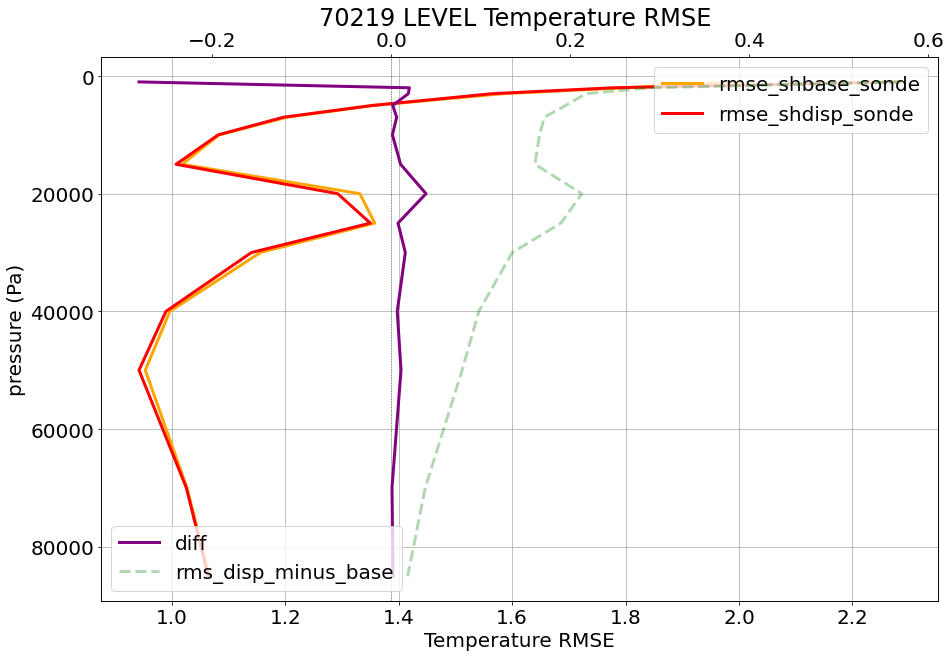

RMSE calculation:  0.2672085762023926


In [19]:
show_date = False
diff = True
stat = '70219'
compare_to = 'fc'
year = '1980'
maxtimediff = pd.Timedelta(hours=2)
dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*' + stat + '*_CEUAS_merged_v1.nc')[0]
df_dict = {}

stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}
rms_sum_dispminusbase={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []
    rms_sum_dispminusbase[i] = []
            
with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    if len(idx) == 0:
        print('nothing found')
#         return 1
    t_idx = file['recordindices']['126'][idx]

    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    
    mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
    mask = np.isin(mask,plevs)
    t_len = len(mask[mask == True])

    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
    df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
    df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
    repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
    df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

    df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

    df_dict['variable'] = ['air_temperature']*t_len
    
    df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df = pd.DataFrame.from_dict(df_dict)
df = df.dropna()

for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
    
    df_mon = df[df.date_time.dt.month == mon]
#     display(df_mon)
    t0 = time.time()
    if compare_to == 'fc':
        files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(mon).zfill(2)+'*.130.nc')[0]
    else:
        files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(mon).zfill(2)+'*.130.nc')[0]
    ds_fc = xr.load_dataset(files)
    print('loading era5 data: ', time.time() - t0)
    t0 = time.time()

    t0 = time.time()       
    for day in df_mon.date_time.drop_duplicates()[:]:
        
        input_data = df_mon[df_mon.date_time == day]
        ds_fc_time = ds_fc.sel(time=day, method='nearest')
#         print(day, pd.Timestamp(ds_fc_time.time.values))
        if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
            continue
        t_list = []
        for i in np.array(ds_fc_time.level): #10,20,...,1000
            step = find_nearest(input_data.z_coordinate, i*100)
            input_data_step = input_data[input_data.z_coordinate == step]
            station_lat = input_data.latitude.iloc[0] + np.array(input_data_step.latitude_displacement)[0]
            station_lon = input_data.longitude.iloc[0] + np.array(input_data_step.longitude_displacement)[0]
            lon = station_lon
            if lon < 0:
                lon = 360.+lon
            ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
            t = ds_now.t.sel(level = i)
            t_list.append(float(t))

        p_ml = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        lon = input_data.longitude.iloc[0]
        if lon < 0:
            lon = 360.+lon
        base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude.iloc[0]], longitude=[lon], method="linear").t)
        for i in range(len(stdplevs)):
            if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
                rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                rms_sum_shbase[stdplevs[i]].append(np.nan)
                rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                rms_sum_sonde[stdplevs[i]].append(np.nan)
                rms_sum_shdisp[stdplevs[i]].append(np.nan)
                rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

            else:
                sq_t = np.squeeze(base_t)
                t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
                t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
                input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                t_sonde = float(input_data_step.observation_value)
    #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                t_adjsonde = float(input_data_step.observation_value - input_data_step.RASE_bias_estimate)# - float(input_data_step['an_depar@body'])

                rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                rms_sum_shbase[stdplevs[i]].append(t_base)
                rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                rms_sum_sonde[stdplevs[i]].append(t_sonde)
                rms_sum_shdisp[stdplevs[i]].append(t_disp)
                rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)
                
    print('calculating mon: ',mon, time.time() - t0)

                
print('valid ascents: ', len(rms_sum_shdisp[50000]))
t0 = time.time()
rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]
rms_dispmbase=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    if show_date:    
        print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    if show_date:    
        print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    if show_date:    
        print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    if show_date:
        print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
    rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
    if show_date:
        print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


print('')

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_shdisp_sonde')

ax1_4 = ax1.twiny()
ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
if diff:
    ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title(str(stat)+' LEVEL Temperature RMSE ')
maplt.show()
maplt.close()
print('RMSE calculation: ', time.time()-t0)


In [10]:
def trajectory_rmse (stats, year, month=False, sel_time=False, show_ascents=False, show_date=False, min_disp=0, compare_to='fc', diff=False):
    print('compare to: ', compare_to)
    maxtimediff = pd.Timedelta(hours=2)
    for stat in stats:
        t0 = time.time()
        statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*' + stat + '*_CEUAS_merged_v1.nc')
        df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
        print('reading converted_v9: ', time.time()-t0)
        t0 = time.time()
        # 2020 only
        df = df[df.date_time.dt.year == year]
        # night only -> ~ 00:00
        if sel_time:
            df = df[np.isin(df.date_time.dt.hour,time)]
        print('selecting from converted_v9: ', time.time()-t0)
        t0 = time.time()

        from scipy.signal import savgol_filter
        # stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
        stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
        rmse_sum_shbase_sonde={}
        rmse_sum_shbase_adjsonde={}
        rmse_sum_shdisp_sonde={}
        rmse_sum_shdisp_adjsonde={}
        rms_sum_shbase={}
        rms_sum_adjsonde={}
        rms_sum_sonde={}
        rms_sum_shdisp={}
        rms_sum_dispminusbase={}

        for i in stdplevs:
            rmse_sum_shbase_sonde[i] = []
            rmse_sum_shbase_adjsonde[i] = []
            rmse_sum_shdisp_sonde[i] = []
            rmse_sum_shdisp_adjsonde[i] = []
            rms_sum_shbase[i] = []
            rms_sum_adjsonde[i] = []
            rms_sum_sonde[i] = []
            rms_sum_shdisp[i] = []
            rms_sum_dispminusbase[i] = []
        
        if month == False:
            month = [1,2,3,4,5,6,7,8,9,10,11,12]
        else:
            month = [month]
        for m in month:
            print('month: ', m)
            t0 = time.time()
            if compare_to == 'fc':
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(m).zfill(2)+'*.130.nc')[0]
            else:
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(m).zfill(2)+'*.130.nc')[0]
            ds_fc = xr.load_dataset(files)
            print('loading era5 data: ', time.time()-t0)
            t0 = time.time()
            df_mon = df[df.date_time.dt.month == m]
            print('selecting era5 data: ', time.time()-t0)
            t0 = time.time()
            
            for day in df_mon.date_time.drop_duplicates()[:]:
                try:
                    test = df_mon[df_mon.date_time == day]
                    if show_date:
                        print(day)

                    ds_fc_time = ds_fc.sel(time=day, method='nearest')
                    t0 = time.time()
                    if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                        continue


                    t = test[test.observed_variable == 126]
                    t = t.rename(columns={'observation_value':'temperature'})
                    t = t.drop(columns='observed_variable')

                    u = test[test.observed_variable == 104]
                    u = u.rename(columns={'observation_value':'u'})
                    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    v = test[test.observed_variable == 105]
                    v = v.rename(columns={'observation_value':'v'})
                    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

                    input_data = input_data.dropna()
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
                    if (np.abs(np.nanmax(phys_model[0])) < min_disp) and (np.abs(np.nanmax(phys_model[1])) < min_disp):
        #                 print(np.nanmax(phys_model[0]), np.nanmax(phys_model[1]))
                        continue
                    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
                    input_data['calc_latd'] = np.array(phys_model[0])
                    input_data['calc_lond'] = np.array(phys_model[1])
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    input_data = input_data.reset_index()

                    
        #                 display(ds_fc_time)
                #     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
                #     df_fc_loc = ds_fc_loc.to_dataframe()

                #     display(input_data)
                    t_list = []
                    for i in np.array(ds_fc_time.level): #10,20,...,1000
                        step = find_nearest(input_data.z_coordinate, i*100)
                #         print('step - level: ', step)
                        input_data_step = input_data[input_data.z_coordinate == step]
                #         print('displacement: ', input_data_step.calc_latd)
                        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
                #         print(i, input_data.latitude[0], station_lat)
                        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
                #         print(i, input_data.longitude[0], station_lon)
                        lon = station_lon
                        if lon < 0:
                            lon = 360.+lon
                        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                #         print('selected lat: ', float(ds_now.latitude))
                        t = ds_now.t.sel(level = i)
                        t_list.append(float(t))

                #     print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
                #     print(stat)
                #     print(day)
                    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
                    lon = input_data.longitude[0]
                    if lon < 0:
                        lon = 360.+lon
                    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[lon], method="linear").t)
                    for i in range(len(stdplevs)):
                        if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
#                             print(stdplevs[i] , find_nearest(input_data.z_coordinate,stdplevs[i]))
                            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_shbase[stdplevs[i]].append(np.nan)
                            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shdisp[stdplevs[i]].append(np.nan)
                            rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                        else:
                            sq_t = np.squeeze(base_t)
                            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
                            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
                            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                            t_sonde = float(input_data_step.temperature)
                #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                            t_adjsonde = float(input_data_step.temperature)# - float(input_data_step['an_depar@body'])

                            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                            rms_sum_shbase[stdplevs[i]].append(t_base)
                            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                            rms_sum_sonde[stdplevs[i]].append(t_sonde)
                            rms_sum_shdisp[stdplevs[i]].append(t_disp)
                            rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)


                    if show_ascents:
                        fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    #                         plt_sonde_t = []

    #                         for pl in stdplevs:
                        base = []
                        disp = []
                        sond = []
                        plev = []
                        for i in range(len(stdplevs)):
                            base.append(rms_sum_shbase[stdplevs[i]][-1])
                            disp.append(rms_sum_shdisp[stdplevs[i]][-1])
                            sond.append(rms_sum_sonde[stdplevs[i]][-1])
                            plev.append(stdplevs[i])

    #                             if np.abs(pl - find_nearest(input_data.z_coordinate, pl)) > 500:
    #                                 plt_sonde_t.append(np.nan)
    #                             else:
    #                                 apl = find_nearest(input_data.z_coordinate, pl)
    #                                 plt_sonde_t.append(float(input_data[input_data.z_coordinate == apl].temperature))
    #                         ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base tempterature')
    #                         ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced temperature')
    #                         ax1.plot(np.array(plt_sonde_t), np.array(stdplevs), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')

                        ax1.plot(np.array(base), np.array(plev), color = 'green', alpha = 0.6, label='base tempterature')
                        ax1.plot(np.array(disp), np.array(plev), color = 'blue', alpha = 0.2,ls = '--', label='displaced temperature')
                        ax1.plot(np.array(sond), np.array(plev), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')

    #                         ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
                    #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
                        ax1.set_ylabel('pressure (Pa)')
                        ax1.set_xlabel('temperature (K)')
                        ax1.tick_params(axis='y')
                        ax1.set_ylim(ax1.get_ylim()[::-1])
                        ax1.legend()
                        ax1.grid()
                        maplt.show()
                        maplt.close()
                except:
                    pass
                print('done with all days: ', time.time()-t0)
            
        print('valid ascents: ', len(rms_sum_shdisp[50000]))
        t0 = time.time()
        rmse_shbase_sonde=[]
        rmse_shbase_adjsonde=[]
        rmse_shdisp_sonde=[]
        rmse_shdisp_adjsonde=[]

        rms_shbase=[]
        rms_adjsonde=[]
        rms_sonde=[]
        rms_shdisp=[]
        rms_dispmbase=[]

        for i in range(len(stdplevs)):
            rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
            rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
            rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
            rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

            rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
            if show_date:    
                print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
            rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
            rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
            rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
            if show_date:
                print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
            rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
            if show_date:
                print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


        print('')

        fig, ax1 = maplt.subplots(figsize = (15,10))
        ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='RMSE Undisplaced Sonde')
        ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='RMSE Displaced Sonde')
#         ax1.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
#         ax1.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')
        
        ax1_4 = ax1.twiny()
        ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
        if diff:
            ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='Difference')
        # ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

#         ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
#         ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
        ax1_4.legend(loc='lower left')
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_ylabel('pressure (Pa)')
        ax1.set_xlabel('Temperature RMSE')
        ax1.legend(loc='upper right')
        ax1.grid()

        maplt.title(str(stat)+' LEVEL Temperature RMSE ')
        maplt.show()
        maplt.close()
        print('RMSE calculation: ', time.time()-t0)


In [11]:
# stats = ['70219','11035','10393']
# year = 1970
# time = False
# month = 1
# trajectory_rmse (stats=stats, year=year, month=month, sel_time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=False)

compare to:  fc
reading converted_v9:  188.72947311401367
selecting from converted_v9:  55.33510112762451
month:  1
loading era5 data:  46.78081560134888
selecting era5 data:  0.028162479400634766
done with all days:  0.13736844062805176
done with all days:  0.009888410568237305
done with all days:  0.011457681655883789
done with all days:  0.01242518424987793
done with all days:  0.011542558670043945
done with all days:  0.01153707504272461
done with all days:  0.011402368545532227
done with all days:  0.011621713638305664
done with all days:  0.013886690139770508
done with all days:  0.008449077606201172
done with all days:  0.008223295211791992
done with all days:  0.008362054824829102
done with all days:  0.009124040603637695
done with all days:  0.009672164916992188
done with all days:  0.00965261459350586
done with all days:  0.008764266967773438
done with all days:  0.00954437255859375
done with all days:  0.009953737258911133
done with all days:  0.010085582733154297
done with 

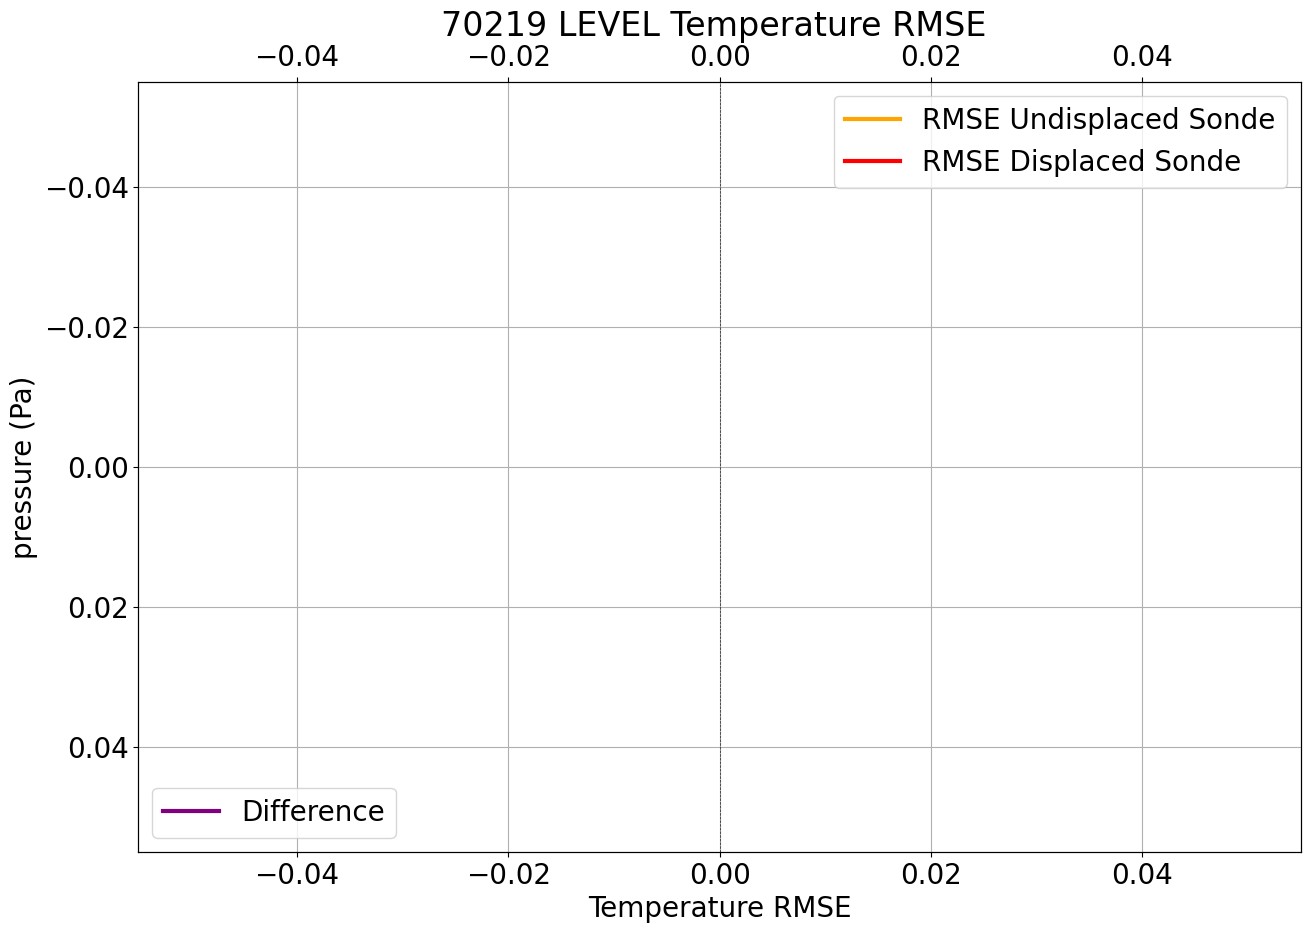

RMSE calculation:  0.6726188659667969


In [13]:
stats = ["70219"]
year = 1980
sel_time = False
month = False
trajectory_rmse(
    stats=stats,
    year=year,
    month=month,
    sel_time=sel_time,
    show_ascents=False,
    show_date=False,
    min_disp=0,
    compare_to="fc",
    diff=True,
)

In [ ]:
time.time()

# US West and East Coast

In [ ]:
import json
with open('/users/staff/a1400070/scratch/hug/config/active.json', 'r') as f:
    active = json.load(f)
active = pd.DataFrame(active).transpose()

active = active[active[0] < 1300000000]
active = active.reset_index()
active = active.rename(columns={'index':'statid'})

import plotly.express as px
fig = px.scatter_geo(active, lat=2, lon=3, hover_name='statid', width= 1000, height=600, )
fig.show()

In [ ]:
# east
stats = ['72208']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

In [ ]:
# west
stats = ['72393']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

In [ ]:
# east
stats = ['72208']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

In [ ]:
# west
stats = ['72393']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

# Forecast

In [ ]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['11035']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

# Analysis

In [ ]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['11035']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')